# Task 2
### Models used:
- Visual Geometry Group - 12 layers
- Vision Transformer

Runs can be seen through Wandb link provided in README

Wandb Link: [Common Test 2 Wandb](https://wandb.ai/mihikasanghi/ML4SCI_task2/reports/Task-2-Report--Vmlldzo3NDI5MjYy)

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from torchmetrics.classification import Accuracy, BinaryAccuracy
from torchmetrics.classification import ROC, BinaryROC
import os
from torchmetrics import AUROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from torchsummary import summary
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
- Converted parquet dataframe to pandas dataframe and saving in a pickle file
- Restarted kernel to clear up RAM and start working with pickle files instead of parquet file for convinience
- Converted all values to float, normalised it and concatenated them to form 1 big data file
- Split data into train and test sets

I had to split the preprocessing part into multiple steps due to constraints on available RAM

In [2]:
# Data Preprocessing

parquet_file = 'Data/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'
parquet_file2 = 'Data/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet'
parquet_file3 = 'Data/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'

table = pq.read_table(parquet_file)
table2 = pq.read_table(parquet_file2)
table3 = pq.read_table(parquet_file3)

table = table.to_pandas()
table2 = table2.to_pandas()
table3 = table3.to_pandas()

table.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_1.pickle')
table2.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_2.pickle')
table3.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_3.pickle')

def convert_to_float(arr):
        if isinstance(arr, np.ndarray):
            return np.array([convert_to_float(x) for x in arr], dtype=float)
        else:
            return float(arr)
        
big_file = pd.read_pickle('/scratch/mihika.sanghi/task2_data/parquet_1.pickle')
big_file2 = pd.read_pickle('/scratch/mihika.sanghi/task2_data/parquet_2.pickle')
big_file3 = pd.read_pickle('/scratch/mihika.sanghi/task2_data/parquet_3.pickle')

big_file['X_jets'] = big_file['X_jets'].apply(convert_to_float)
big_file2['X_jets'] = big_file2['X_jets'].apply(convert_to_float)
big_file3['X_jets'] = big_file3['X_jets'].apply(convert_to_float)

big_file_combined = pd.concat([big_file, big_file2, big_file3], ignore_index=True)

mean = np.mean([np.mean(x, axis=(1,2)) for x in big_file_combined['X_jets']], axis=0)

std = np.std([np.std(x, axis=(1,2)) for x in big_file_combined['X_jets']], axis=0)

for i in range(len(big_file_combined['X_jets'])):
    for j in range(len(big_file_combined['X_jets'][i])):
                big_file_combined['X_jets'][i][j] = (big_file_combined['X_jets'][i][j] - mean[j]) / std[j]

big_file_combined = big_file_combined.sample(frac=1).reset_index(drop=True)

# big_file_combined.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_combined_normalised_reshaped.pickle')

train_df = big_file_combined.iloc[:int(0.8*len(big_file_combined))]
val_df = big_file_combined.iloc[int(0.8*len(big_file_combined)):]

train_df.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_combined_normalised_reshaped_train.pickle')
val_df.to_pickle('/scratch/mihika.sanghi/task2_data/parquet_combined_normalised_reshaped_val.pickle')

In [2]:
class ParticleImageDataset(Dataset):
    def __init__(self, split='train'):
        if split == 'train':  
            self.df = pd.read_pickle('/scratch/mihika.sanghi/parquet_combined_normalised_reshaped_train.pickle')
        else:
            self.df = pd.read_pickle('/scratch/mihika.sanghi/parquet_combined_normalised_reshaped_val.pickle')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return torch.tensor(self.df.iloc[idx]['X_jets'], dtype=torch.float32), torch.tensor(self.df.iloc[idx]['y'], dtype=torch.float32)

In [4]:
train_dataset = ParticleImageDataset()
val_dataset = ParticleImageDataset(split='val')

In [9]:
train_dataset[42]

(tensor([[[-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
          [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
          [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
          ...,
          [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
          [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
          [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042]],
 
         [[-0.0431, -0.0431, -0.0431,  ..., -0.0431, -0.0431, -0.0431],
          [-0.0431, -0.0431, -0.0431,  ..., -0.0431, -0.0431, -0.0431],
          [-0.0431, -0.0431, -0.0431,  ..., -0.0431, -0.0431, -0.0431],
          ...,
          [-0.0431, -0.0431, -0.0431,  ..., -0.0431, -0.0431, -0.0431],
          [-0.0431, -0.0431, -0.0431,  ..., -0.0431, -0.0431, -0.0431],
          [-0.0431, -0.0431, -0.0431,  ..., -0.0431, -0.0431, -0.0431]],
 
         [[-0.1001, -0.1001, -0.1001,  ..., -0.1001, -0.1001, -0.1001],
          [-0.1001, -0.1001,

In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=12)

In [6]:
class VGG12(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG12, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4608, 2048),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 2048),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(2048, num_classes))
        self.calculate_accuracy = Accuracy(task='multiclass', num_classes=2, top_k=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
model = VGG12().to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 100
best_val_acc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        accuracy = model.calculate_accuracy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy
    print(f"Epoch {epoch+1}, Training loss: {running_loss/len(train_loader)}, Accuracy: {running_accuracy/len(train_loader)}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        running_loss = 0.0
        running_accuracy = 0.0
        with torch.no_grad():
            for i, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                labels = labels.long()
                loss = criterion(outputs, labels)
                accuracy = model.calculate_accuracy(outputs, labels)
                running_loss += loss.item()
                running_accuracy += accuracy
        val_acc = running_accuracy/len(val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'ckpts/best_model_VGG12_1e-2.pt')
        print(f"Epoch {epoch+1}, Validation loss: {running_loss/len(val_loader)}, Accuracy: {val_acc}")

print('Finished Training')

100%|██████████| 1742/1742 [05:22<00:00,  5.41it/s]

Epoch 1, Training loss: 1.5296411443967908, Accuracy: 0.6343947052955627



100%|██████████| 436/436 [00:21<00:00, 19.96it/s]


Epoch 1, Validation loss: 0.6772507452363268, Accuracy: 0.5724887847900391


100%|██████████| 1742/1742 [05:19<00:00,  5.45it/s]

Epoch 2, Training loss: 0.6338230020416864, Accuracy: 0.6695752143859863



100%|██████████| 436/436 [00:21<00:00, 19.94it/s]


Epoch 2, Validation loss: 0.6102851772116958, Accuracy: 0.6853302121162415


100%|██████████| 1742/1742 [05:19<00:00,  5.45it/s]

Epoch 3, Training loss: 0.6437760631711009, Accuracy: 0.6651406288146973



100%|██████████| 436/436 [00:21<00:00, 19.96it/s]


Epoch 3, Validation loss: 0.6246309645405603, Accuracy: 0.6862000226974487


 41%|████      | 713/1742 [02:09<03:06,  5.52it/s]

In [21]:
# load the saved model
model = VGG12().to(device)
model.load_state_dict(torch.load('ckpts/best_model_VGG12_0.01.pt'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
all_labels = []
all_outputs = []

model.eval()
running_loss = 0.0
running_accuracy = 0.0
with torch.no_grad():
    for i, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        
        all_labels.extend(labels.cpu())
        all_outputs.extend(outputs.cpu())
        accuracy = model.calculate_accuracy(outputs, labels)
        running_loss += loss.item()
        running_accuracy += accuracy
        
val_acc = running_accuracy/len(val_loader)
print(f"Validation loss: {running_loss/len(val_loader)}, Accuracy: {val_acc}")

100%|██████████| 436/436 [00:21<00:00, 20.37it/s]

Validation loss: 0.5730125852817789, Accuracy: 0.7358638048171997


ROC Score: 0.7759538888931274


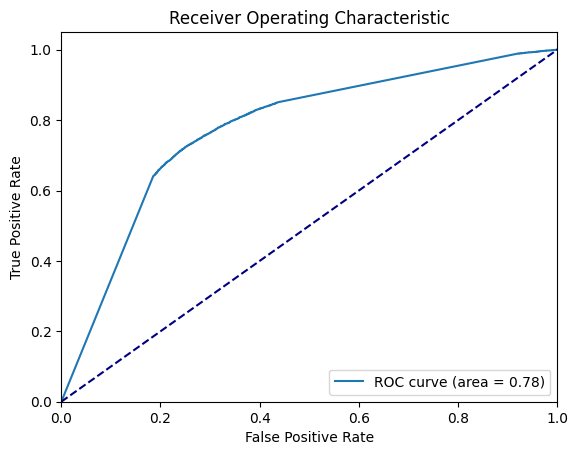

In [24]:
# Convert lists to tensors
all_labels_tensor = torch.tensor(all_labels)
all_outputs_tensor = torch.stack(all_outputs, dim=0)
all_outputs_tensor = all_outputs_tensor[:, 1]

# Initialize metric
metric = AUROC(task='binary')

# Update state with predictions and targets
metric.update(all_outputs_tensor, all_labels_tensor)

# Compute ROC
roc_score = metric.compute()

print(f"ROC Score: {roc_score}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_tensor.cpu(), all_outputs_tensor.detach().cpu())

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Vision Transformer Code

In [2]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)
        self.calculate_accuracy = BinaryAccuracy()

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [3]:
class ParticleImageDataset(Dataset):
    def __init__(self, split='train'):
        
        if split == 'train':  
            self.df = pd.read_pickle('/scratch/mihika.sanghi/parquet_combined_normalised_reshaped_train.pickle')

        else:
            self.df = pd.read_pickle('/scratch/mihika.sanghi/parquet_combined_normalised_reshaped_val.pickle')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return torch.tensor(self.df.iloc[idx]['X_jets'], dtype=torch.float32), torch.tensor(self.df.iloc[idx]['y'], dtype=torch.float32)

In [4]:
train_dataset = ParticleImageDataset()
val_dataset = ParticleImageDataset(split='val')
train_dataset[42]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=13)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=13)

In [5]:
model = ViT(image_size = (125, 125), patch_size = (5, 5), num_classes = 2, dim = 128, depth = 6, heads = 8, mlp_dim = 128).to(device)

## Finding the number of parameters in the ViT model

In [6]:
summary(model, input_size=(3, 125, 125))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1              [-1, 625, 75]               0
         LayerNorm-2              [-1, 625, 75]             150
            Linear-3             [-1, 625, 128]           9,728
         LayerNorm-4             [-1, 625, 128]             256
           Dropout-5             [-1, 626, 128]               0
         LayerNorm-6             [-1, 626, 128]             256
            Linear-7            [-1, 626, 1536]         196,608
           Softmax-8          [-1, 8, 626, 626]               0
           Dropout-9          [-1, 8, 626, 626]               0
           Linear-10             [-1, 626, 128]          65,664
          Dropout-11             [-1, 626, 128]               0
        Attention-12             [-1, 626, 128]               0
        LayerNorm-13             [-1, 626, 128]             256
           Linear-14             [-1, 6

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
best_val_acc = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        accuracy = model.calculate_accuracy(torch.argmax(outputs, dim=1), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy
    print(f"Epoch {epoch+1}, Training loss: {running_loss/len(train_loader)}, Accuracy: {running_accuracy/len(train_loader)}")

    if (epoch + 1) % 1 == 0:
        model.eval()
        running_loss = 0.0
        running_accuracy = 0.0
        with torch.no_grad():
            for i, data in tqdm(enumerate(val_loader, 0), total=len(val_loader)):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                labels = labels.long()
                loss = criterion(outputs, labels)
                accuracy = model.calculate_accuracy(torch.argmax(outputs, dim=1), labels)
                running_loss += loss.item()
                running_accuracy += accuracy
        val_acc = running_accuracy/len(val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'ckpts/best_model_ViT_1e-2.pt')
        print(f"Epoch {epoch+1}, Validation loss: {running_loss/len(val_loader)}, Accuracy: {val_acc}")

print('Finished Training')

## Data Visualization
Provide path to parquet file

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


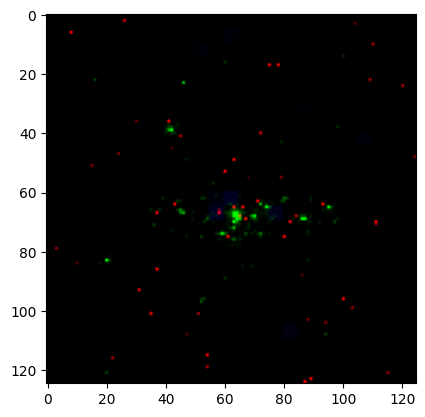

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


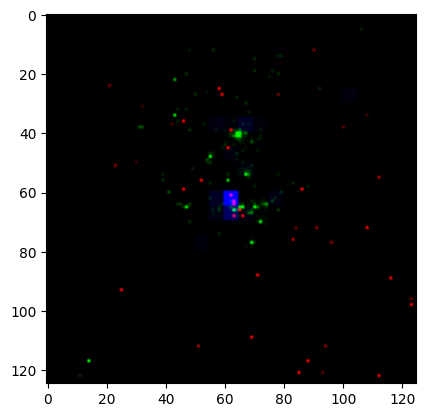

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


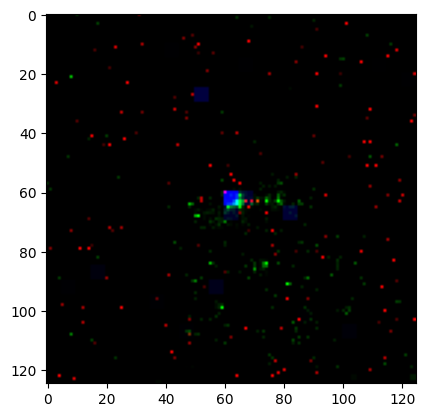

In [ ]:
path_name = 'path to original parquet file'
table = pq.read_table(path_name)

arr = table['X_jets'][0].as_py()
arr = np.array(arr)
arr_transposed = np.transpose(arr, (1, 2, 0))
plt.imshow(arr_transposed, cmap='gray')
plt.show()

arr2 = table2['X_jets'][0].as_py()
arr2 = np.array(arr2)
arr_transposed2 = np.transpose(arr2, (1, 2, 0))
plt.imshow(arr_transposed2, cmap='gray')
plt.show()

arr3 = table3['X_jets'][0].as_py()
arr3 = np.array(arr3)
arr_transposed3 = np.transpose(arr3, (1, 2, 0))
plt.imshow(arr_transposed3, cmap='gray')
plt.show()